In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random

In [2]:
def show_row(images):
    fig, axes = plt.subplots(nrows=1, ncols=len(images))
    fig.set_figheight(6)
    fig.set_figwidth(len(images)*3)
    
    for ax, img in zip(axes, images):
        ax.imshow(img, cmap='gray')
    plt.show()    

In [3]:
def montage(images):
    width = images[0].shape[0]
    
    placeholder = np.zeros(
        (width, width*len(images))
    )
    for i in range(len(images)):
        placeholder[:, i*width:(i+1)*width] = images[i]
        
    fig, ax = plt.subplots(nrows=1, ncols=1)
    fig.set_figheight(6)
    fig.set_figwidth(len(images)*3)
    
    ax.imshow(placeholder, cmap='gray')
    
    ax.set_xticks([i*width for i in range(len(images)+1)])
    ax.set_xticklabels([str(i+1) for i in range(len(images)+1)], fontsize=12)
    ax.minorticks_off()
    ax.set_xlim(0, width*len(images))
    
    plt.show()

<hr>

# Quantum dots Generation

In [4]:
def create_quantum_dot(radius_in_pixels:int, gaussian:bool=True):
    distance_matrix = np.zeros(
        (2*radius_in_pixels+1, 2*radius_in_pixels+1, 2*radius_in_pixels+1), 
        dtype=np.float32
    )
    grid1d = np.arange(0,2*radius_in_pixels+1,1)
    X,Y,Z = np.meshgrid(grid1d,grid1d,grid1d)
    
    for x in range(2*radius_in_pixels+1):
        for y in range(2*radius_in_pixels+1):
            for z in range(2*radius_in_pixels+1):
                distance_matrix[x,y,z] = np.linalg.norm(
                    np.array([
                        (X - radius_in_pixels)[x,y,z],
                        (Y - radius_in_pixels)[x,y,z], 
                        (Z - radius_in_pixels)[x,y,z]
                    ])
                )
    
    if gaussian:
        #fwhm is full-width-half-maximum, which can be thought of as an effective radius.
        fwhm = radius_in_pixels
        result = np.exp(-4*np.log(2) * (distance_matrix)**2 / fwhm**2)
    else:
        result = 1*(distance_matrix <= radius_in_pixels)
        
    return result

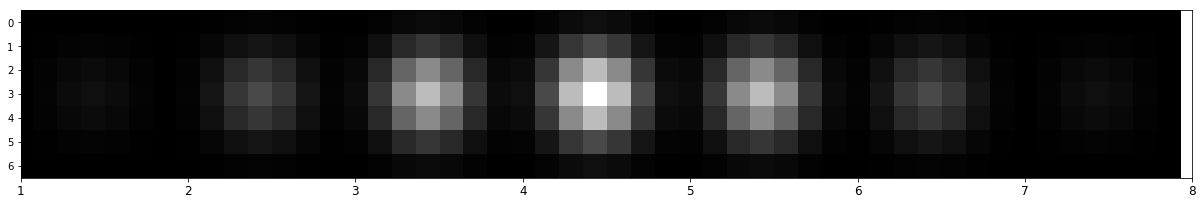

In [5]:
dot = create_quantum_dot(radius_in_pixels=3, gaussian=True)
montage([img for img in dot])

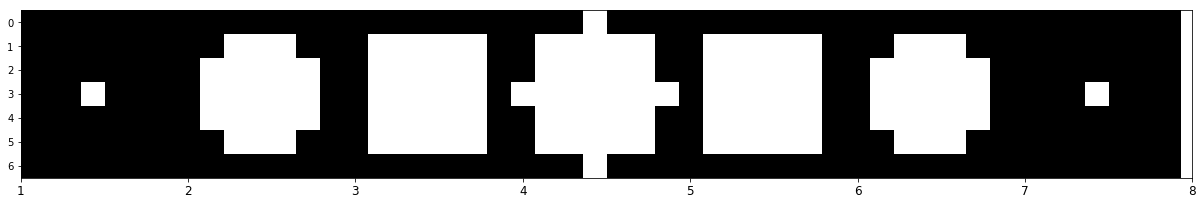

In [6]:
dot = create_quantum_dot(radius_in_pixels=3, gaussian=False)
montage([img for img in dot])

## Space

In [7]:
from collections import Counter

In [8]:
def create_space(linear_size:int):
    space = np.zeros(
        (linear_size,linear_size,linear_size), 
        dtype=np.float32
    )
    return space

    
def idx_generator(space_size:int, dot_size:int, density:float):
    available_size = [dot_size, space_size-dot_size]
    total_available_num_of_dots = (available_size[1] - available_size[0])//dot_size
    if density == 0.0:
        return np.array([])
    elif density == 1.0:
        coords = np.linspace(
            available_size[0], 
            available_size[1], 
            total_available_num_of_dots, 
            dtype=int
        )
        random.shuffle(coords)
        return coords
    else:
        num_of_dots = int(total_available_num_of_dots*density)
        coords = np.random.randint(
            available_size[0], 
            available_size[1], 
            num_of_dots
        )
        return coords


def coords_generator_3d(space_size:int, dot_size:int, density:float):
    available_size = [dot_size, space_size-dot_size]
    linear_num_of_dots = (available_size[1] - available_size[0])//dot_size
    total_available_num_of_dots = np.power(linear_num_of_dots, 3)
    
    if density == 0.0:
        coords = np.array([])
    elif density == 1.0:
        coords_1d = np.linspace(
            available_size[0], 
            available_size[1], 
            total_available_num_of_dots, 
            dtype=int
        )
        coords = np.array([coords_1d,coords_1d,coords_1d]).T
    else:
        num_of_dots = int(total_available_num_of_dots*density)
        if num_of_dots %3 ==1:
            num_of_dots += 2
        elif num_of_dots %3 ==2:
            num_of_dots += 1
        coords = np.random.randint(
            available_size[0], 
            available_size[1], 
            num_of_dots
        )
        coords= coords.reshape(-1, 3)
    
    troubles = np.zeros((len(coords), len(coords)),dtype=np.uint8)
    for i in range(len(coords)):
        for j in range(len(coords)):
            if i != j:
                distance = np.linalg.norm(coords[i] - coords[j])
                if distance <= dot_size:
                    troubles[i,j] = 1
    
    too_close_points = np.nonzero(troubles)
    coords = coords[ [i for i in range(len(coords)) if i not in too_close_points[0]] ]
    if len(too_close_points[0]) != 0:
        print(f'Warning! too_close_points {len(too_close_points)}')
    return coords


def place_dot(space, dot, dot_coords, dot_radius):
    start_idx = dot_coords-dot_radius
    space[
        start_idx[0] : start_idx[0]+dot.shape[0],
        start_idx[1] : start_idx[1]+dot.shape[1],
        start_idx[2] : start_idx[2]+dot.shape[2]
    ] = dot
    return space

In [9]:
def synthesize(space_size:int, dot_size:int, density:float, dot_type_gaussian:bool=True):
    dot_radius = dot_size//2
    space = create_space(space_size)
    coords = coords_generator_3d(space_size=space_size, dot_size=dot_size, density=density)
    print(f'{len(coords)} dots')
    dot_instance = create_quantum_dot(radius_in_pixels=dot_radius, gaussian=dot_type_gaussian)
    
    for (x,y,z) in coords:
        space = place_dot(space, dot_instance, np.array([x,y,z]), dot_radius)
    return space

Warning! too_close_points 2
6 dots


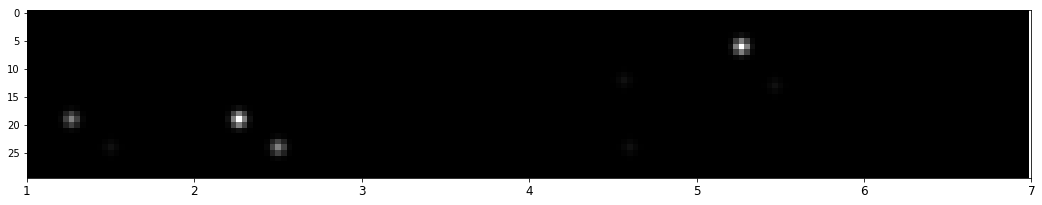

In [10]:
data = synthesize(30, 5, 0.9, True)
montage([data[:,:,i] for i in [5, len(data)//5, len(data)//3, len(data)//2, 2*len(data)//3, len(data)-5]])

<hr>

# PSF generation

In [11]:
def backbone_slices(size, radius):
    up = np.zeros((size,size), dtype=np.float32)
    middle, down = up.copy(), up.copy()
    
    center_coordinates = (size//2, size//2) 
    startAngle = 0
    endAngle = 360
    color = 1.0
    thickness = -1
    
    axesLength = (radius, radius//2)
    angle = 0
    up = cv2.ellipse(up, center_coordinates, axesLength, angle, startAngle, endAngle, color, thickness) 
    angle = 90
    down = cv2.ellipse(down, center_coordinates, axesLength, angle, startAngle, endAngle, color, thickness) 
    
    middle = cv2.circle(middle, center_coordinates, radius//2, color, thickness)
    return up, middle, down

def backbone_slices_2(size, radius):
    up = np.zeros((size,size), dtype=np.float32)
    middle, down = up.copy(), up.copy()
    
    center_coordinates = (size//2, size//2) 
    color = 1.0
    thickness = -1
    
    up = cv2.circle(up, center_coordinates, radius//4, color, thickness)
    middle = cv2.circle(middle, center_coordinates, radius//2, color, thickness)
    down = cv2.circle(down, center_coordinates, radius//4, color, thickness)
    return up, middle, down

def interpolate(z_size, backbone_slices, normalize=True):
    up, middle, down = backbone_slices
    z_stack = np.zeros((up.shape[0], up.shape[1], z_size), dtype=np.float32)
    z_stack[:,:,0] = up
    z_stack[:,:,-1] = down
    z_stack[:,:,z_stack.shape[2]//2] = middle
    
    z_up_middle = z_stack.shape[2]//2
    for z_idx in range(1,z_up_middle):
        z_stack[:,:,z_idx] = z_stack[:,:,0]*(1-z_idx/z_up_middle) + z_stack[:,:,z_up_middle]*(z_idx/z_up_middle)
    
    for z_idx in range(z_up_middle+1, z_stack.shape[2]):
        z_stack[:,:,z_idx] = z_stack[:,:,z_up_middle]*(1-(z_idx-z_up_middle)/z_up_middle) + z_stack[:,:,-1]*((z_idx-z_up_middle)/z_up_middle)
    
    gaussian_size = int(up.shape[0]//2)
    gaussian = create_quantum_dot(radius_in_pixels=gaussian_size, gaussian=True)
    
    z_pad = 0
    for z_idx in range(0,z_size):
        z_stack[:,:,z_idx] *= gaussian[:,:,z_pad]
        
    
    if normalize:
        z_stack /= z_stack.sum()
    return z_stack

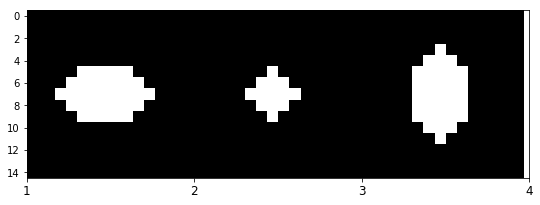

In [12]:
montage( backbone_slices(15,4) )

(11, 11, 11)


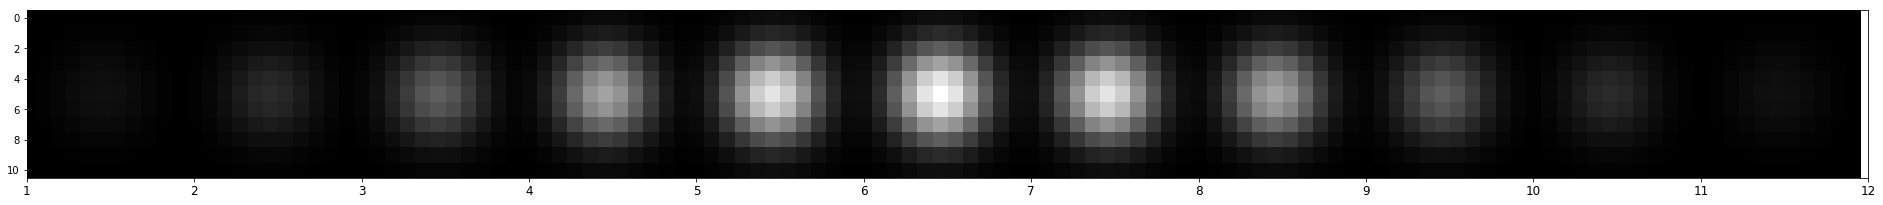

In [13]:
dot = create_quantum_dot(radius_in_pixels=5, gaussian=True)
print(dot.shape)
montage([dot[:,:,i] for i in range(dot.shape[2])] )

(31, 31, 5) 1.0


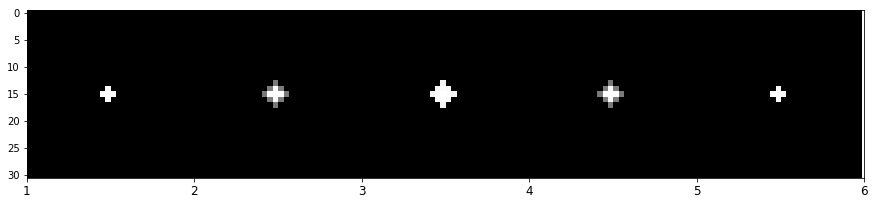

In [14]:
z_size = 5
up, middle, down = backbone_slices_2(31,4)
psf = interpolate(z_size, (up, middle, down))
print(psf.shape, psf.sum())
montage([psf[:,:,sl] for sl in range(psf.shape[2])])

# Convolution

In [15]:
from scipy.signal import fftconvolve

Warning! too_close_points 2
48 dots


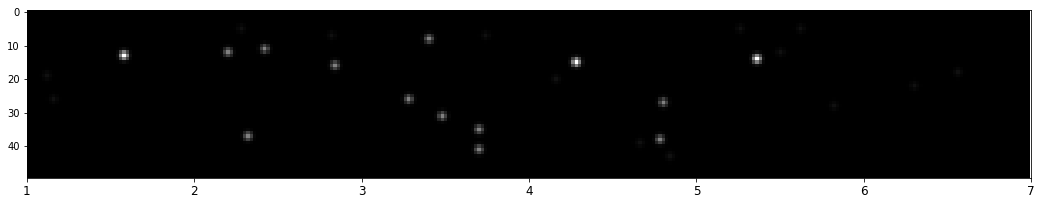

In [16]:
data = synthesize(50, 5, 0.5, True)
montage([data[:,:,i] for i in [5, len(data)//5, len(data)//3, len(data)//2, 2*len(data)//3, len(data)-5]])

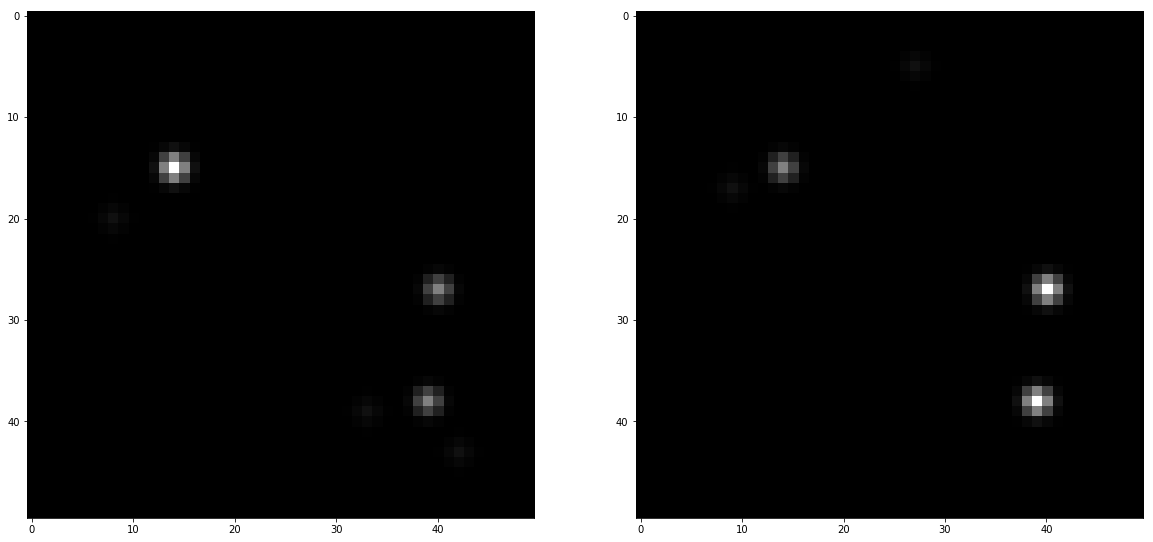

In [17]:
plt.figure(figsize=(20,10))
plt.subplot(121)
plt.imshow(data[:,:,25], cmap='gray')
plt.subplot(122)
plt.imshow(data[:,:,26], cmap='gray')
plt.show()

(15, 15, 7) 0.9999999


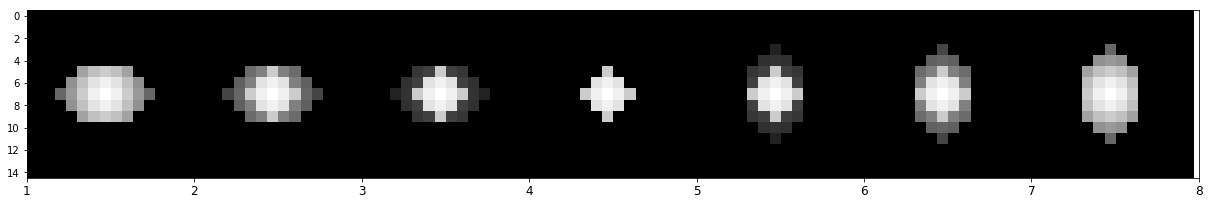

In [18]:
z_size = 7
psf = interpolate(z_size, backbone_slices(15,4))
print(psf.shape, psf.sum())
montage([psf[:,:,sl] for sl in range(psf.shape[2])])

In [19]:
result = fftconvolve(data, psf, mode='same')
print(result.shape)

(50, 50, 50)


/home/roman_kiryanov/anaconda3/lib/python3.7/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)


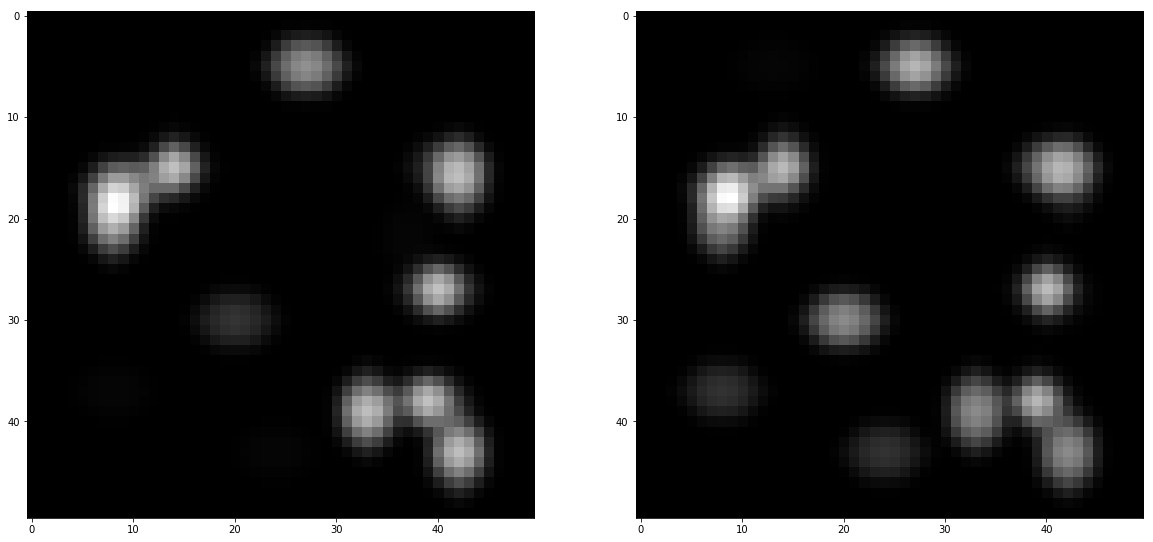

In [20]:
plt.figure(figsize=(20,10))
plt.subplot(121)
plt.imshow(result[:,:,25], cmap='gray')
plt.subplot(122)
plt.imshow(result[:,:,26], cmap='gray')
plt.show()

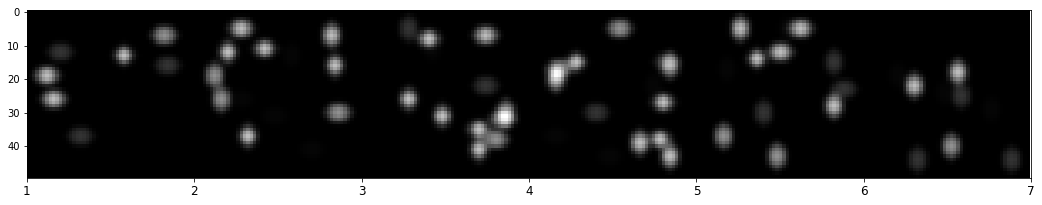

In [21]:
montage([result[:,:,i] for i in [5, len(data)//5, len(data)//3, len(data)//2, 2*len(data)//3, len(data)-5]])

<hr>

## Esrgan

In [22]:
import torch
import sys
import os

In [23]:
sys.path.insert(0, '/home/roman_kiryanov/mmsr/codes/')
sys.path.insert(0, '/home/roman_kiryanov/mmsr/codes/models/archs/')
import RRDBNet_arch as arch

In [24]:
device = torch.device(1) 
device = 'cpu' #torch.device(1) 
print(os.getcwd())

/home/roman_kiryanov


In [25]:
esrgan_base_model = arch.RRDBNet(3, 3, 64, 23, gc=32)

In [26]:
from collections import OrderedDict

alpha = 0.5
net_finetune = torch.load('./mmsr/experiments/1801_RRDB_ESRGANx4_Z1/models/10000_G.pth')
net_ESRGAN = torch.load('./mmsr/experiments/pretrained_models/RRDB_ESRGAN_x4.pth')
net_interp = OrderedDict()

In [27]:
print('Interpolating with alpha = ', alpha)

for k, v_PSNR in net_finetune.items():
    v_ESRGAN = net_ESRGAN[k]
    net_interp[k] = (1 - alpha) * v_PSNR + alpha * v_ESRGAN

Interpolating with alpha =  0.5


In [28]:
model = esrgan_base_model
model.load_state_dict(net_interp, strict=True)
model.eval()
model = model.to(device)

In [29]:
def predict_float(model, image):
    image = np.transpose([image,image,image], (1,2,0))
    
    image = torch.from_numpy(np.transpose(image[:, :, [2, 1, 0]], (2, 0, 1))).float()
    image = image.unsqueeze(0)
    image = image.to(device)

    # Generate eSRGAN image
    with torch.no_grad():
        image_cpu = model(image)
    image_cpu = image_cpu.data.squeeze().float().cpu().clamp_(0, 1).numpy()
    del image
    image_cpu = np.transpose(image_cpu[[2, 1, 0], :, :], (1, 2, 0))
    
    torch.cuda.empty_cache()
    return image_cpu[:,:,0]

In [30]:
import time

In [31]:
def timer(func_to_decorate):
    def decorator(*original_args, **original_kwargs):
        ts = time.time()
        outputs = func_to_decorate(*original_args, **original_kwargs)
        tf = time.time()
        print(f'Time {round(tf-ts,5)} s')
        return outputs
    return decorator

## Deconvolution

In [32]:
from skimage import restoration

In [33]:
def extract_psf(image, kernel, normalize = False):
    assert (image.shape[0] >= kernel.shape[0]) and (image.shape[1] >= kernel.shape[1]), 'Image is less than kernel'
    drop_channel = False
    if image.ndim ==2:
        image = np.expand_dims(image, 2)
        kernel = np.expand_dims(kernel, 2)
        drop_channel = True
    psf = np.zeros_like(image).astype(np.float32)
    
    for z in range(image.shape[2]):
        blurred_2d_image = image[:,:,z].astype(np.float32)
        kernel_2d_image = kernel[:,:,z].astype(np.float32)
        
        blurred_2d_image = np.clip(blurred_2d_image,0,1)
        kernel_2d_image = np.clip(kernel_2d_image,0,1)
        """
        print(f'Range blurred {blurred_2d_image.min(), blurred_2d_image.max()}')
        print(f'Range kernel {kernel_2d_image.min(), kernel_2d_image.max()}')
        plt.figure(figsize=(8,8))
        plt.subplot(221)
        plt.imshow(blurred_2d_image, cmap='gray')
        plt.subplot(222)
        plt.imshow(kernel_2d_image, cmap='gray')
        
        fft_bic = np.fft.fftshift(np.fft.fft2(blurred_2d_image))
        fft_kernel = np.fft.fftshift(np.fft.fft2(kernel_2d_image))
        plt.subplot(223)
        plt.imshow(np.log(np.abs(fft_bic)), cmap='gray')
        plt.subplot(224)
        plt.imshow(np.log(np.abs(fft_kernel)), cmap='gray')
        plt.show()"""
        
        dec_psf = restoration.unsupervised_wiener(blurred_2d_image, kernel_2d_image)[0]
        #dec_psf = restoration.wiener(blurred_2d_image, kernel_2d_image, balance=0.1)[0]
        if normalize:
            dec_psf = dec_psf*(dec_psf>0)
            dec_psf = dec_psf/dec_psf.sum()
        psf[:,:,z] = dec_psf
    
    if drop_channel:
        psf = np.squeeze(psf,2)
    return psf

In [34]:
@timer
def restore(img, z, depth, gan):
    input_substack = np.zeros((img.shape[0], img.shape[1], 2*depth+1))
    if (z-depth) < 0:
        z += depth
    elif (z+depth) >= img.shape[2]:
        z = img.shape[2]- depth
    
    for z_idx, i in enumerate( range(-depth, depth+1) ):
        input_substack[:,:,z_idx] = img[:,:,z+i]
        #print(z+i)
    
    center = depth
    generated = np.zeros((img.shape[0]*4, img.shape[1]*4, 2*depth+1))
    bicubic = np.zeros((img.shape[0]*4, img.shape[1]*4, 2*depth+1))
    for i in range(input_substack.shape[2]):
        generated[:,:,i] = predict_float(gan, input_substack[:,:,i])
        bicubic[:,:,i] = cv2.resize(input_substack[:,:,i], (int(img.shape[1]*4), int(img.shape[0]*4)), cv2.INTER_CUBIC)
    
    print('Images generated')
    psf_v1 = np.zeros((img.shape[0]*4, img.shape[1]*4, 2*depth+1))
    psf_v2 = np.zeros((img.shape[0]*4, img.shape[1]*4, 2*depth+1))
    for i in range(input_substack.shape[2]):
        psf_v1[:,:,i] = extract_psf(bicubic[:,:,i], generated[:,:,i], normalize=False)
        
    print('psf_1 extracted')
    for i in np.arange(-depth, 0, 1):
        psf_v2[:,:,center+i] = extract_psf(bicubic[:,:,center+i], generated[:,:,center], normalize=False)
    
    psf_v2[:,:,center] = extract_psf(bicubic[:,:,center], generated[:,:,center], normalize=False)
    for i in np.arange(1, depth+1, 1):
        psf_v2[:,:,center+i] = extract_psf(bicubic[:,:,center+i], generated[:,:,center], normalize=False)
    print('psf_2 extracted')
    
    return psf_v1, psf_v2

<hr>

# Test Launch


In [35]:
import imutils
import pickle
import tifffile as tiff

20 dots


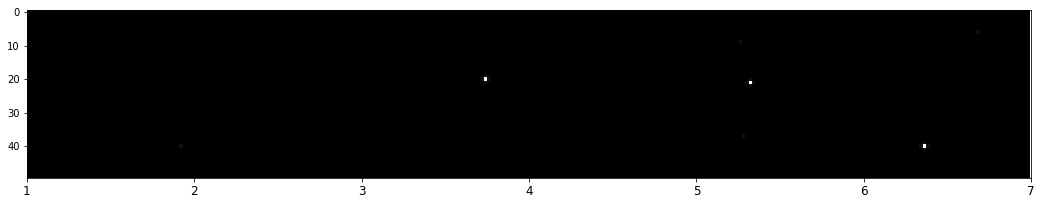

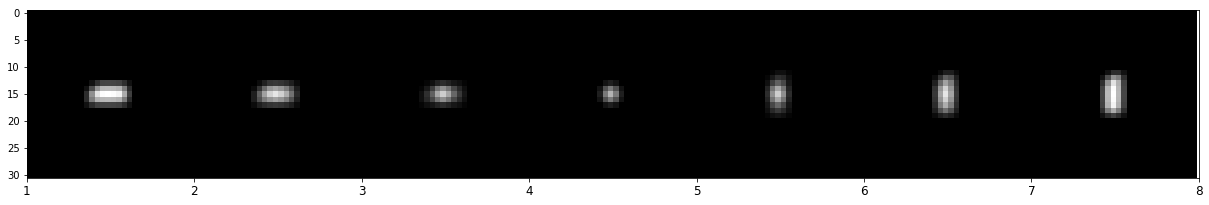

/home/roman_kiryanov/anaconda3/lib/python3.7/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)


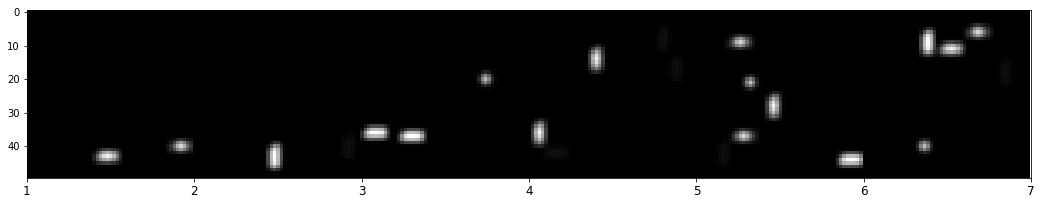

In [64]:
space_size = 50
dot_size = 2
percentage = 0.005
dot_type_gaussian = True

data = synthesize(space_size, dot_size, percentage, dot_type_gaussian=dot_type_gaussian)
montage([data[:,:,i] for i in [5, len(data)//5, len(data)//3, len(data)//2, 2*len(data)//3, len(data)-5]])


psf_z_size = 7
psf_xy_size = 3
smooth_size = 3
smooth_sigma = smooth_size//2

up, middle, down = backbone_slices(31,psf_xy_size)

psf = interpolate(psf_z_size, (up, middle, down))
for i in range(psf.shape[2]):
    psf[:,:,i] = cv2.GaussianBlur(psf[:,:,i], (smooth_size,smooth_size), smooth_sigma)
montage([psf[:,:,sl] for sl in range(psf.shape[2])])


result = fftconvolve(data, psf, mode='same')
montage([result[:,:,i] for i in [5, len(data)//5, len(data)//3, len(data)//2, 2*len(data)//3, len(data)-5]])

In [87]:
combined = np.zeros((50*9,50, 7))
x = 0
for i in range(1, 1+7*7, 7):
    print(i)
    tmp = result[:,:,i:i+7]
    print(tmp.shape)
    combined[x*50:(x+1)*50, :, :] = tmp
    x += 1

1
(50, 50, 7)
8
(50, 50, 7)
15
(50, 50, 7)
22
(50, 50, 7)
29
(50, 50, 7)
36
(50, 50, 7)
43
(50, 50, 7)


In [88]:
print(combined.shape)

(450, 50, 7)


In [89]:
combined = combined.reshape(50*3,50*3, 7)

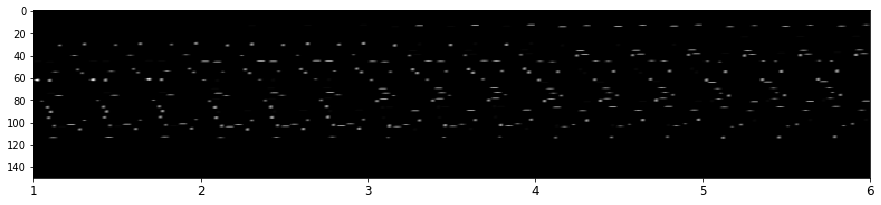

In [90]:
montage([combined[:,:,i] for i in range(5)])

In [93]:
depth = 3
z = 3

print(depth, z)

3 3


In [94]:
_, psf2_t = restore(combined, z, depth, model)

Images generated
psf_1 extracted
psf_2 extracted
Time 39.60197 s


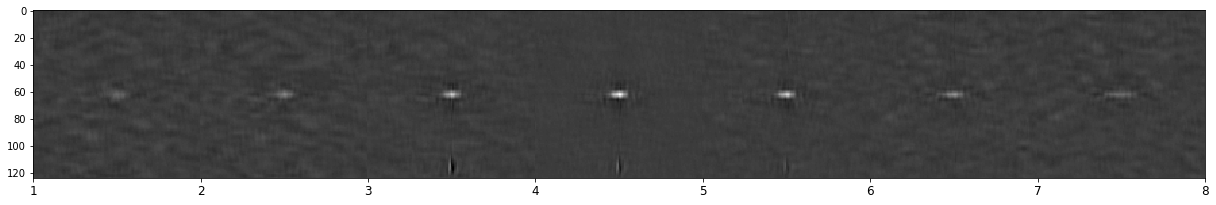

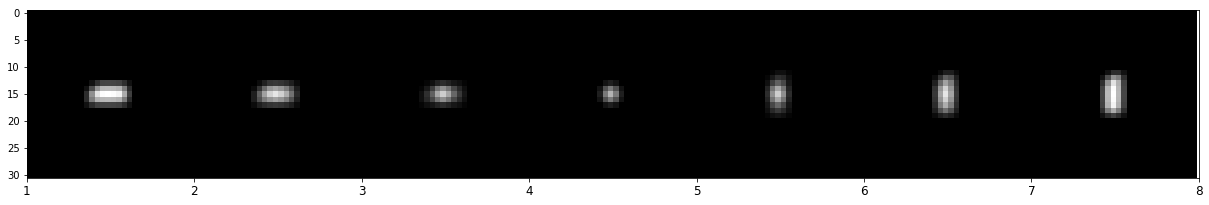

In [95]:
center = psf2_t.shape[0]//2
pad = psf.shape[0]*2

montage([psf2_t[center-pad:center+pad,center-pad:center+pad,i] for i in range(psf2_t.shape[2])] )

montage([psf[:,:,i] for i in range(psf.shape[2])] )

In [96]:
%%capture
depth = psf_z_size//2
z = space_size//2

print(depth, z)

psf1, psf2 = restore(result, z, depth, model)
stride = 1

for z in range(depth, space_size-depth, stride):
    psf1_t, psf2_t = restore(result, z, depth, model)
    psf2 = np.mean([psf2,psf2_t], axis=0)

space_size = 30
dot_size = 2
percentage = 0.01
dot_type_gaussian = True
psf_z_size = 5
psf_xy_size = 3
smooth = 3,1
stride = 1

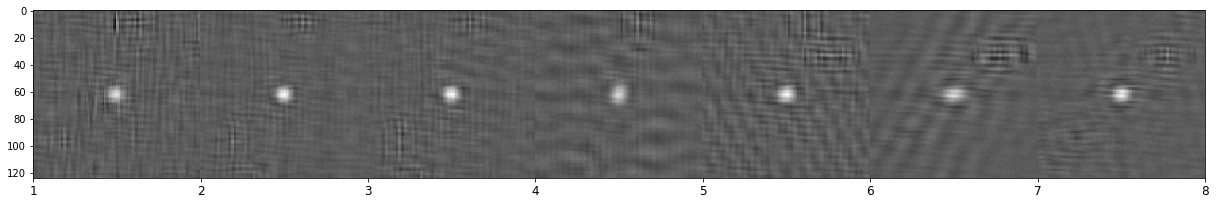

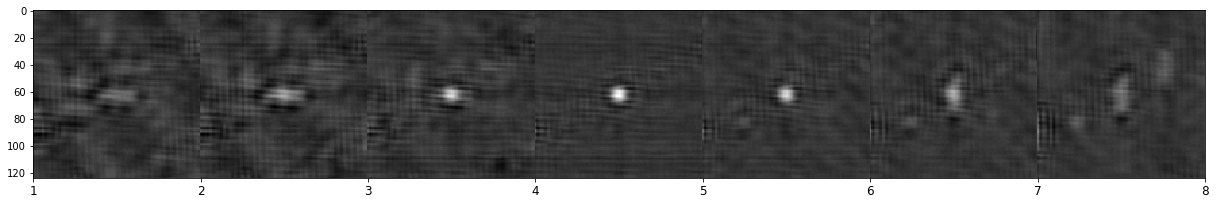

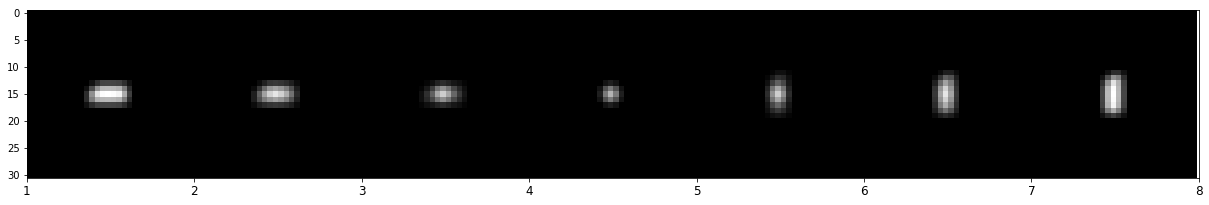

In [97]:
center = psf1.shape[0]//2
pad = psf.shape[0]*2

#center-pad:center+pad,center-pad:center+pad
montage([psf1[center-pad:center+pad,center-pad:center+pad,i] for i in range(psf1.shape[2])] )

montage([psf2[center-pad:center+pad,center-pad:center+pad,i] for i in range(psf1.shape[2])] )

montage([psf[:,:,i] for i in range(psf.shape[2])] )

In [98]:
psf_extracted = psf2[center-pad:center+pad,center-pad:center+pad,:]

psf_extracted.min(), psf_extracted.max(), psf_extracted.shape

(-0.004713626777928932, 0.018020594882143796, (124, 124, 7))

In [99]:
psf_encoded = psf
psf_encoded.min(),psf_encoded.max(), psf_encoded.shape

(0.0, 0.01087834, (31, 31, 7))

0.0 1.0 (31, 31, 7)


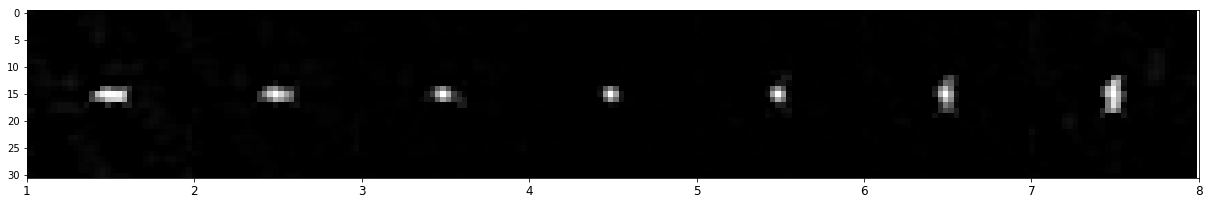

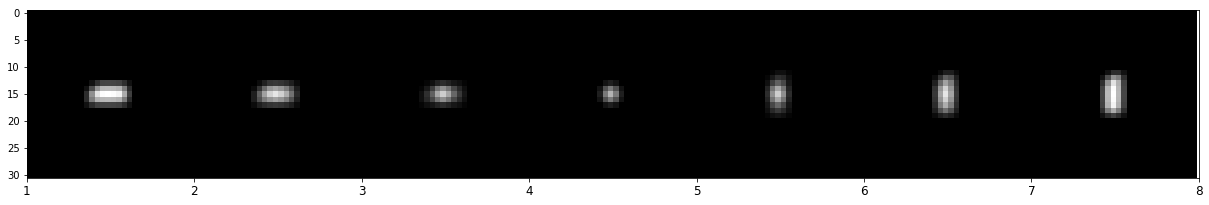

In [135]:
psf_extracted_2 = np.array([imutils.resize(psf_extracted[:,:,i], width = psf_encoded.shape[0]) for i in range(psf_extracted.shape[2])])
psf_extracted_2 = np.transpose(psf_extracted_2, (1,2,0))
#psf_extracted_2 -= psf_extracted_2.min()
psf_extracted_2 = np.clip(psf_extracted_2, 0, np.max(psf_extracted_2))
psf_extracted_2 = psf_extracted_2*0.1 + 0.9*psf_extracted_2*(psf>0)
psf_extracted_2 = np.array([psf_extracted_2[:,:,i]/psf_extracted_2[:,:,i].max() for i in range(psf_extracted_2.shape[2])])
psf_extracted_2 = np.transpose(psf_extracted_2, (1,2,0))

print(psf_extracted_2.min(), psf_extracted_2.max(), psf_extracted_2.shape)

montage([psf_extracted_2[:,:,i] for i in range(psf_encoded.shape[2])] )
montage([psf[:,:,i] for i in range(psf_encoded.shape[2])] )

In [136]:
#folder_to_save = './synthetic_data_deconv_28042020_2/'
folder_to_save = './synthetic_data_deconv_05052020/'

In [137]:
psf_extracted_2_tmp = 255*psf_extracted_2/psf_extracted_2.max()
psf_encoded_tmp = 255*psf_encoded/psf_encoded.max() 

In [138]:
for i in range(psf_encoded_tmp.shape[2]):
    tiff.imsave( 
        os.path.join(folder_to_save, '05052020_psf_extracted_C0000Z'+'{:04d}'.format(i)+'.tif'), 
        np.uint8(psf_extracted_2_tmp[:,:,i]) 
    )
    tiff.imsave( 
        os.path.join(folder_to_save, '05052020_psf_encoded_C0001Z'+'{:04d}'.format(i)+'.tif'), 
        np.uint8(psf_encoded_tmp[:,:,i]) 
    )
print('Tout')

Tout


<br>

# Experiments

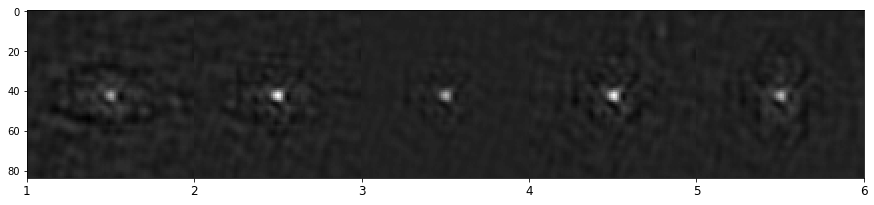

In [297]:
temp = psf2[center-pad:center+pad,center-pad:center+pad,:]
for i in [0,1,3,4]:
    temp[:,:,i] += temp[:,:,2]
    
montage([temp[:,:,i] for i in range(temp.shape[2])] )

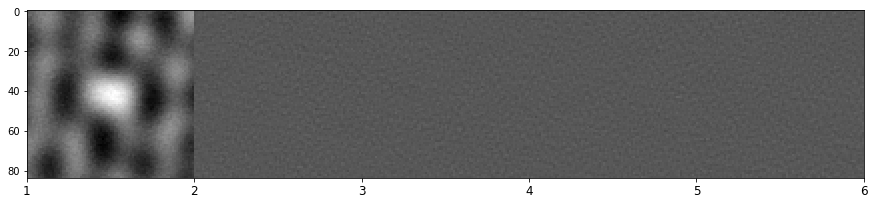

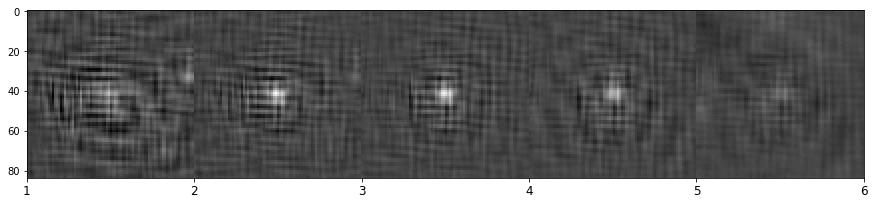

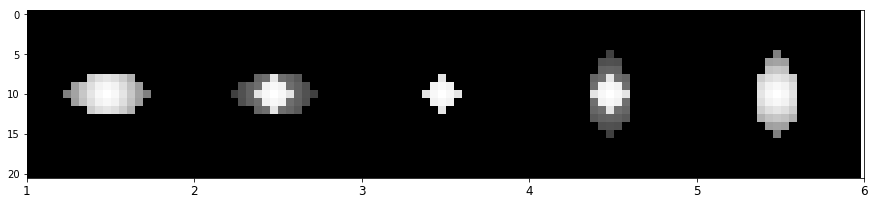

In [177]:
# 0.005 - 2 dots
center = psf1.shape[0]//2
pad = psf.shape[0]*2

#center-pad:center+pad,center-pad:center+pad
montage([psf1[center-pad:center+pad,center-pad:center+pad,i] for i in range(psf1.shape[2])] )

montage([psf2[center-pad:center+pad,center-pad:center+pad,i] for i in range(psf1.shape[2])] )

montage([psf[:,:,i] for i in range(psf.shape[2])] )

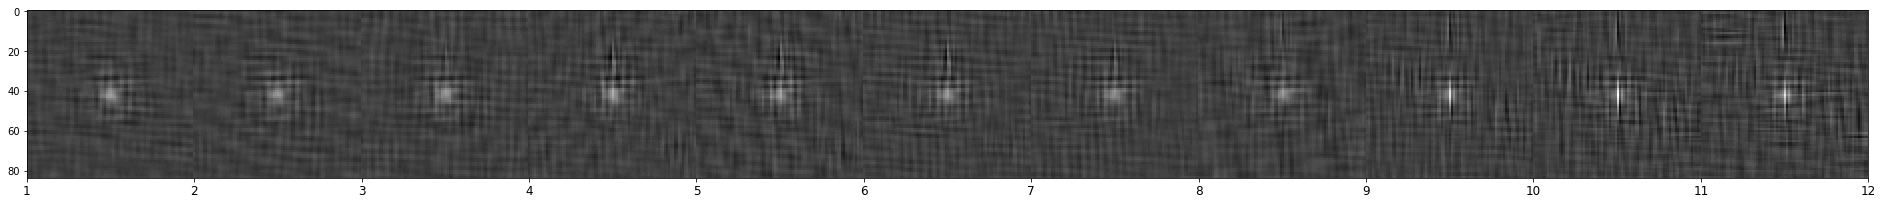

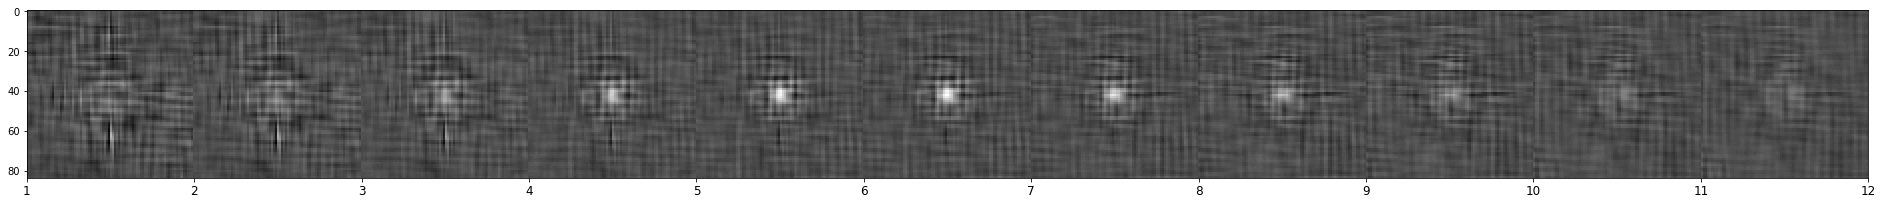

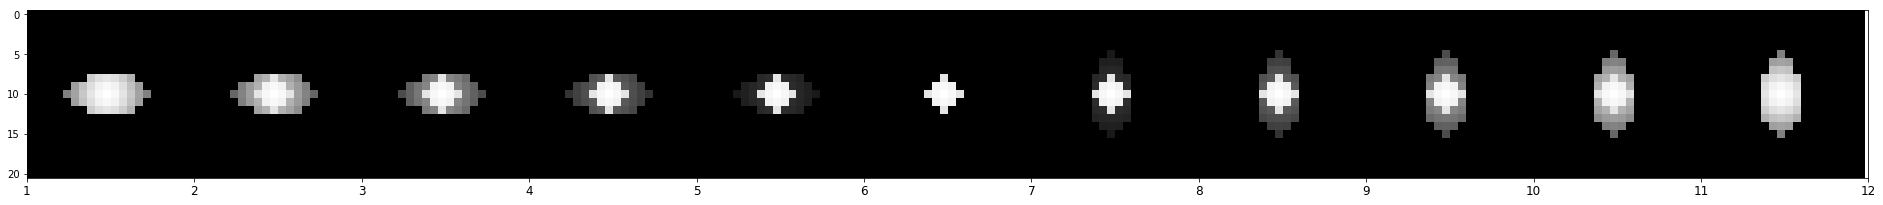

In [105]:
# 0.1 - 30 dots
center = psf1.shape[0]//2
pad = psf.shape[0]*2

#center-pad:center+pad,center-pad:center+pad
montage([psf1[center-pad:center+pad,center-pad:center+pad,i] for i in range(psf1.shape[2])] )

montage([psf2[center-pad:center+pad,center-pad:center+pad,i] for i in range(psf1.shape[2])] )

montage([psf[:,:,i] for i in range(psf.shape[2])] )

In [67]:
pad = psf.shape[0]*2
cropped_psf = psf2[center-pad:center+pad,center-pad:center+pad,:]
cropped_psf.shape, cropped_psf.max(), cropped_psf.sum(), cropped_psf.min()

((84, 84, 7), 0.0374612199815374, 6.024362166833984, -0.02141299102265748)

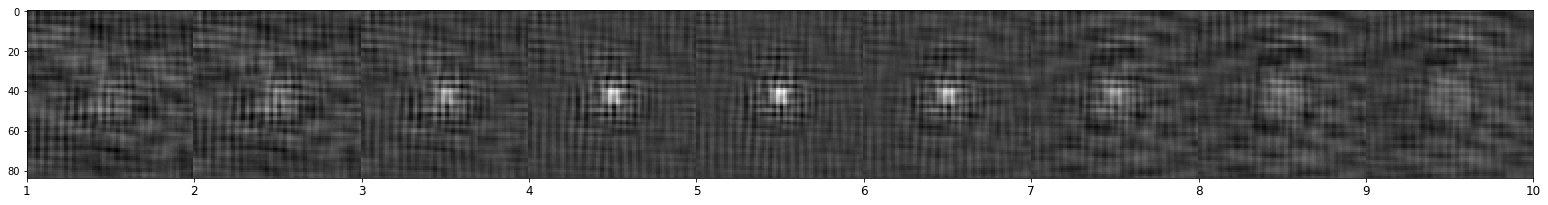

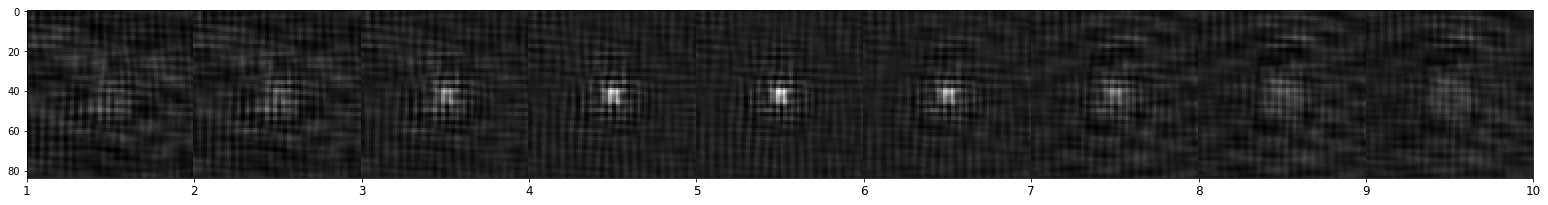

((84, 84, 9), 51.20808817447897, 406976.03173017805, 0.0)

In [306]:
test_to_save = cropped_psf - cropped_psf.min()
test_to_save = test_to_save/test_to_save.sum()
montage([test_to_save[:,:,i] for i in range(test_to_save.shape[2])] )

test_to_save = np.power(test_to_save,1.5)
test_to_save = test_to_save*(10e7)
#test_to_save = test_to_save*(test_to_save>0.5)

montage([test_to_save[:,:,i] for i in range(test_to_save.shape[2])] )
test_to_save.shape, test_to_save.max(), test_to_save.sum(), test_to_save.min()

In [307]:
import tifffile as tiff

In [308]:
folder = './synthetic_data_deconv_27022020/psf_extract_qd_4_psf_21_4_9_deconv_depth_5'

for i in range(2*depth+1):
    tiff.imsave( 
        os.path.join(folder, 'psf_recov', 'C0000Z'+'{:04d}'.format(i)+'.tif'), 
        np.float32(test_to_save[:,:,i]) 
    )
    tiff.imsave( 
        os.path.join(folder, 'psf_real', 'C0001Z'+'{:04d}'.format(i)+'.tif'), 
        np.float32(psf[:,:,i]) 
    )
print('Tout')

Tout


### d
data = synthesize(50, 5, 0.03, True)

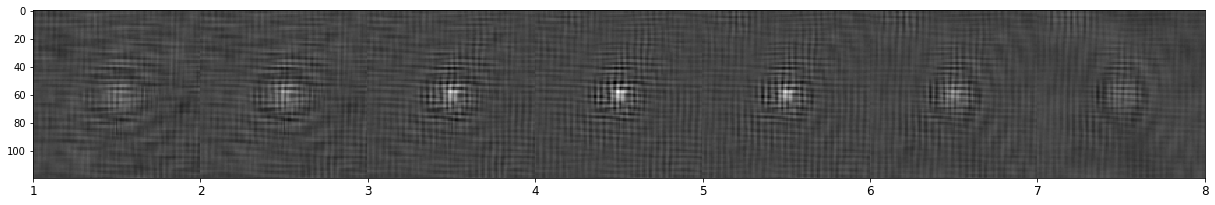

((120, 120, 7), 3.6408572574533536e-05, 0.9999999999999996, 0.0)

In [120]:
test_to_save = cropped_psf - cropped_psf.min()
test_to_save = test_to_save/test_to_save.sum()
montage([test_to_save[:,:,i] for i in range(test_to_save.shape[2])] )

test_to_save.shape, test_to_save.max(), test_to_save.sum(), test_to_save.min()

# Increase

In [35]:
@timer
def increase(stack3D, model):
    coef =4
    superresolved =  np.zeros((stack3D.shape[0]*coef, stack3D.shape[1]*coef, stack3D.shape[2]))
    bicubic = superresolved.copy()
    
    for i in range(stack3D.shape[2]):
        superresolved[:,:,i] = predict_float(model, stack3D[:,:,i])
        bicubic[:,:,i] = cv2.resize(
            stack3D[:,:,i], 
            (superresolved[:,:,i].shape[1], superresolved[:,:,i].shape[0]), 
            cv2.INTER_CUBIC
        )
        
    return superresolved, bicubic

<br>

In [36]:
sr, bic = increase(result, model)

Time 19.31713 s


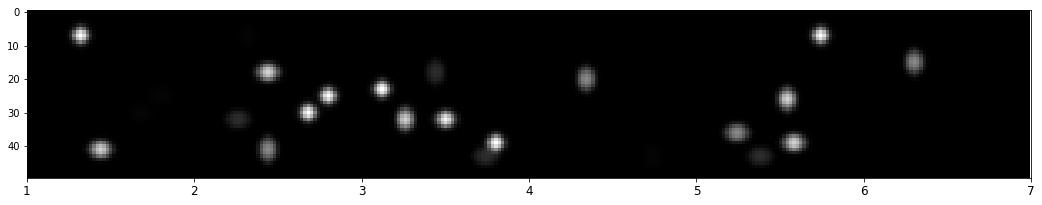

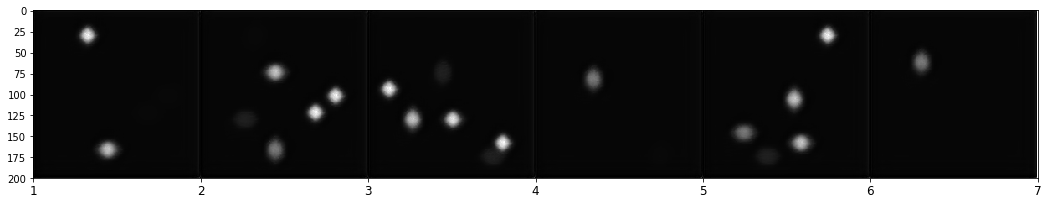

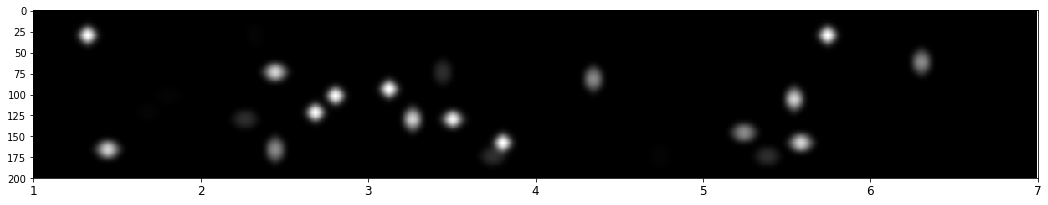

In [37]:
montage([result[:,:,i] for i in [5, len(data)//5, len(data)//3, len(data)//2, 2*len(data)//3, len(data)-5]])

montage([sr[:,:,i] for i in [5, len(data)//5, len(data)//3, len(data)//2, 2*len(data)//3, len(data)-5]])

montage([bic[:,:,i] for i in [5, len(data)//5, len(data)//3, len(data)//2, 2*len(data)//3, len(data)-5]])

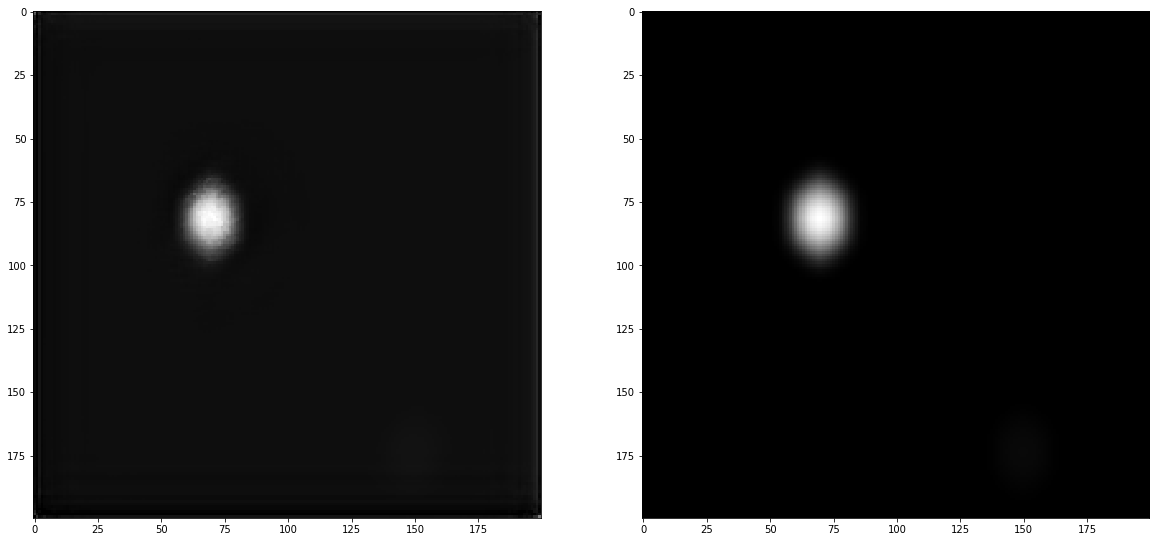

In [38]:
plt.figure(figsize=(20,10))
plt.subplot(121)
plt.imshow(sr[:,:,25], cmap='gray')
plt.subplot(122)
plt.imshow(bic[:,:,25], cmap='gray')
plt.show()

In [39]:
coef = 4
psf_enlarged =  np.zeros((psf.shape[0]*coef, psf.shape[1]*coef, psf.shape[2]))

for i in range(psf.shape[2]):
    psf_enlarged[:,:,i] = cv2.resize(
        psf[:,:,i], 
        (psf_enlarged[:,:,i].shape[1], psf_enlarged[:,:,i].shape[0]), 
        cv2.INTER_CUBIC
    )

print(psf.shape, psf_enlarged.shape)

(15, 15, 7) (60, 60, 7)


In [57]:
result.shape

(50, 50, 50)